In [4]:
# Importing libraries
import spacy
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from transformers import GPT2Tokenizer, GPT2Model
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import re
from datetime import datetime

nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_lg')
#nlp = spacy.load('en_core_web_md')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Isas_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
data = pd.read_csv('all_ECB_speeches.csv',sep = '|')
# Remove non-english speeches
data_drop_nan = data.dropna(subset=data.columns)
data.dropna(subset=data.columns, inplace=True)

# Function to detect language of a given text
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = "Unknown"
    return lang

# Apply the language detection function to each text in your DataFrame
data['language'] = data['contents'].apply(detect_language)

# Filter out the texts that are not in English
data = data[data['language'] == 'en']
# Drop null values
data = data.dropna(subset=['speakers','contents'])
# Reset index
data = data.reset_index(drop=True)
# Remove introduction
for row in range (data.shape[0]):
  try:
    speech = re.split(
        " \d+ (January|February|March|April|May|June|July|August|September|October|November|December) \d{4} ",
        data.loc[row, "contents"])
    data.loc[row, "contents"] = speech[-1]
  except:
    pass  
# Split into sentences
sentences_list = []
for row in range (data.shape[0]):
    text = data.loc[row, "contents"]
    sentences = re.split(r'[.!?]', text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    sentences_list.append(sentences)
data['sentences'] = sentences_list

<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:27: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Isas_\AppData\Local\Temp\ipykernel_7824\810766723.py:27: SyntaxWarning: invalid escape sequence '\d'
  " \d+ (January|February|March|April|May|June|July|August|September|October|November|December) \d{4} ",


In [6]:
print(data["sentences"][0])

['As we approach the end of this legislative term, I wish to sincerely thank this Parliament for collaborating in guiding Europe through economic headwinds and geopolitical upheavals, always with the shared vision of bolstering prosperity and fortifying our resilience', 'Building on this collaborative spirit, today’s debate on your draft resolution on the ECB Annual Report is a pillar of the ongoing dialogue between our two institutions; indeed, it is fundamental to the ECB’s accountability which ensures the democratic legitimacy of our actions', 'Let me start by outlining the current state of the euro area economy and our monetary policy stance', 'I will then focus on the need for a common European response to strengthen euro area resilience and competitiveness', 'Bringing inflation back to target in a challenging economic and geopolitical environment The euro area has been facing significant headwinds from a series of sudden and consecutive shocks which pushed inflation very high in 

In [7]:
data.head()

,date,speakers,title,subtitle,contents,language,sentences
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,[As we approach the end of this legislative te...
1,2024-02-16,Isabel Schnabel,From laggard to leader? Closing the euro area’...,Inaugural lecture of the EMU Lab by Isabel Sch...,"More than 30 years after its inception, Econom...",en,"[More than 30 years after its inception, Econo..."
2,2024-02-15,Christine Lagarde,Hearing of the Committee on Economic and Monet...,"Speech by Christine Lagarde, President of the ...",Today’s hearing is our last before the end o...,en,[Today’s hearing is our last before the end of...
3,2024-02-14,Piero Cipollone,Preserving people’s freedom to use a public me...,"Introductory statement by Piero Cipollone, Mem...",on the digital euro (CON/2023/34)”. See Ar...,en,"[on the digital euro (CON/2023/34)”, See Artic..."
4,2024-02-14,Luis de Guindos,"Monetary policy, financial stability and mediu...","Speech by Luis de Guindos, Vice-President of t...",Over the past few years the euro area economy ...,en,[Over the past few years the euro area economy...


In [8]:
# Remove stopwords and punctuation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stop_words.update(['also', 'ha'])
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

sentences_list = []
original_sentences = []
for row in range (data.shape[0]):
    sentences = data.loc[row, "sentences"]
    original_sentences.append(sentences)
    sentences = [preprocess_text(sentence) for sentence in sentences]
    sentences_list.append(sentences)

data['sentences'] = sentences_list
data['original_sentences'] = original_sentences

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Isas_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Isas_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Isas_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# Create a dictionary of terms for each subject

dict_terms = {'inflation':
              ['inflation', 'prices', 'deflation', 'target', 'consumer prices', 'CPI', 'PPI'],
              'activity':
              ['activity', 'recovery', 'recession', 'expansion', 'output', 'demand', 'supply','GDP', 'employment', 'unemployment', 'labor market'],
              'economic crisis':
              ['crisis', 'recession', 'depression', 'bailout', 'stimulus', 'austerity', 'bankruptcy', 'default'],
              'monetary policy':
              ['monetary policy', 'interest rates', 'central bank', 'money supply', 'quantitative easing', 'policy rate', 'rate cut', 'rate hike', 'forward guidance', 'open market operations', 'reserve requirements'],
}



In [10]:
# Explode the data to have one sentence per row
sentences_df = data.explode('sentences')
# match the original sentences
# TODO
# Drop null values
sentences_df = sentences_df.dropna(subset=['sentences'])

In [11]:
# Find the sentences that contain the terms
topic_list = []
for row in range(sentences_df.shape[0]): 
    sentence = sentences_df.iloc[row, 6]
    topic = [0,0,0,0]
    for i, terms in enumerate(dict_terms.values()):
        for term in terms:
            if term in sentence:
                topic[i] += 1
    topic_list.append(topic)
topic_list

# Add the classification to the DataFrame and infer the topic based on the argmax of the topic list
# if no topic is found, the topic is set to unknown
# if multiple topics are found with the same number of terms, set it as unknown 
sentences_df['topic_matchs'] = topic_list
sentences_df['topic'] = sentences_df['topic_matchs'].apply(lambda x: list(dict_terms.keys())[x.index(max(x))] if max(x) > 0 and x.count(max(x)) == 1 else 'unknown')

In [12]:
clusters = KMeans(n_clusters=4, random_state=0).fit_predict(X)

NameError: name 'X' is not defined

In [13]:
print(clusters[10:100])

sentences_df['cluster'] = clusters

sentences_df

NameError: name 'clusters' is not defined

In [ ]:
# group by topic and cluster
grouped = sentences_df.groupby(['cluster','topic']).size().reset_index(name='counts')
# drop the unknown topic
grouped = grouped[grouped['topic'] != 'unknown']
grouped

,cluster,topic,counts
0,0,activity,13347
1,0,economic crisis,9040
2,0,inflation,11534
3,0,monetary policy,24475
5,1,activity,1491
6,1,economic crisis,369
7,1,inflation,2370
8,1,monetary policy,3251
10,2,activity,172
11,2,economic crisis,97


In [14]:
# plot the clusters for each topic
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster', y='counts', hue='topic', data=grouped)
plt.title('Clusters for each topic')
plt.show()

NameError: name 'grouped' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Isas_\AppData\Roaming\nltk_data...


In [ ]:
def add_sentiment_column(data):
    # Inicializar o analisador de sentimento
    sid = SentimentIntensityAnalyzer()

    # Função para calcular o sentimento médio de um discurso
    def get_overall_sentiment(speech):
        sentence_list = tokenize.sent_tokenize(speech)
        if not sentence_list:
            return None  # Se não há frases, retorna None

        compound_scores = []
        for sentence in sentence_list:
            scores = sid.polarity_scores(sentence)
            compound_scores.append(scores['compound'])

        # Calcular a média dos scores compound
        if compound_scores:
            return sum(compound_scores) / len(compound_scores)
        else:
            return None

    # Aplicar a função ao DataFrame
    data['sentiment'] = data['contents'].apply(get_overall_sentiment)
    return data

# Uso da função
# Suponha que 'data' é o DataFrame com os discursos
data_with_sentiment = add_sentiment_column(data)

In [ ]:
sentences_df.head()

,date,speakers,title,subtitle,contents,language,sentences,original_sentences,topic_matchs,topic,cluster
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,approach end legislative term wish sincerely t...,[As we approach the end of this legislative te...,"[0, 0, 0, 0]",unknown,0
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,building collaborative spirit today debate dra...,[As we approach the end of this legislative te...,"[0, 0, 0, 0]",unknown,0
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,let start outlining current state euro area ec...,[As we approach the end of this legislative te...,"[0, 0, 0, 1]",monetary policy,0
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,focus need common european response strengthen...,[As we approach the end of this legislative te...,"[0, 0, 0, 0]",unknown,0
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,bringing inflation back target challenging eco...,[As we approach the end of this legislative te...,"[2, 1, 0, 0]",inflation,0


In [ ]:
data_with_sentiment.head()

,date,speakers,title,subtitle,contents,language,sentences,original_sentences,sentiment
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,[approach end legislative term wish sincerely ...,[As we approach the end of this legislative te...,0.261251
1,2024-02-16,Isabel Schnabel,From laggard to leader? Closing the euro area’...,Inaugural lecture of the EMU Lab by Isabel Sch...,"More than 30 years after its inception, Econom...",en,[30 year inception economic monetary union wid...,"[More than 30 years after its inception, Econo...",0.107985
2,2024-02-15,Christine Lagarde,Hearing of the Committee on Economic and Monet...,"Speech by Christine Lagarde, President of the ...",Today’s hearing is our last before the end o...,en,"[today hearing last end legislative term, let ...",[Today’s hearing is our last before the end of...,0.231058
3,2024-02-14,Piero Cipollone,Preserving people’s freedom to use a public me...,"Introductory statement by Piero Cipollone, Mem...",on the digital euro (CON/2023/34)”. See Ar...,en,"[digital euro con202334, see article 52 applic...","[on the digital euro (CON/2023/34)”, See Artic...",-0.292950
4,2024-02-14,Luis de Guindos,"Monetary policy, financial stability and mediu...","Speech by Luis de Guindos, Vice-President of t...",Over the past few years the euro area economy ...,en,[past year euro area economy experienced unpre...,[Over the past few years the euro area economy...,0.101526


In [ ]:
print(data_with_sentiment.columns)

Index(['date', 'speakers', 'title', 'subtitle', 'contents', 'language',
       'sentences', 'original_sentences', 'sentiment'],
      dtype='object')


In [ ]:
print(sentences_df.columns)

Index(['date', 'speakers', 'title', 'subtitle', 'contents', 'language',
       'sentences', 'original_sentences', 'topic_matchs', 'topic', 'cluster'],
      dtype='object')


In [ ]:
new_data = pd.merge(sentences_df, data_with_sentiment, on='title', how='inner')

In [ ]:
new_data.head()

,date_x,speakers_x,title,subtitle_x,contents_x,language_x,sentences_x,original_sentences_x,topic_matchs,topic,cluster,date_y,speakers_y,subtitle_y,contents_y,language_y,sentences_y,original_sentences_y,sentiment
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,approach end legislative term wish sincerely t...,[As we approach the end of this legislative te...,"[0, 0, 0, 0]",unknown,0,2024-02-26,Christine Lagarde,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,[approach end legislative term wish sincerely ...,[As we approach the end of this legislative te...,0.261251
1,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,approach end legislative term wish sincerely t...,[As we approach the end of this legislative te...,"[0, 0, 0, 0]",unknown,0,2023-02-15,Christine Lagarde,"Speech by Christine Lagarde, President of the ...",I am very pleased to be back here in this plen...,en,[pleased back plenary room heart european demo...,[I am very pleased to be back here in this ple...,0.341026
2,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,approach end legislative term wish sincerely t...,[As we approach the end of this legislative te...,"[0, 0, 0, 0]",unknown,0,2022-02-14,Christine Lagarde,"Introductory statement by Christine Lagarde, P...",Today’s debate is an important pillar of the E...,en,[today debate important pillar ecbs accountabi...,[Today’s debate is an important pillar of the ...,0.210749
3,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,building collaborative spirit today debate dra...,[As we approach the end of this legislative te...,"[0, 0, 0, 0]",unknown,0,2024-02-26,Christine Lagarde,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,[approach end legislative term wish sincerely ...,[As we approach the end of this legislative te...,0.261251
4,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,building collaborative spirit today debate dra...,[As we approach the end of this legislative te...,"[0, 0, 0, 0]",unknown,0,2023-02-15,Christine Lagarde,"Speech by Christine Lagarde, President of the ...",I am very pleased to be back here in this plen...,en,[pleased back plenary room heart european demo...,[I am very pleased to be back here in this ple...,0.341026


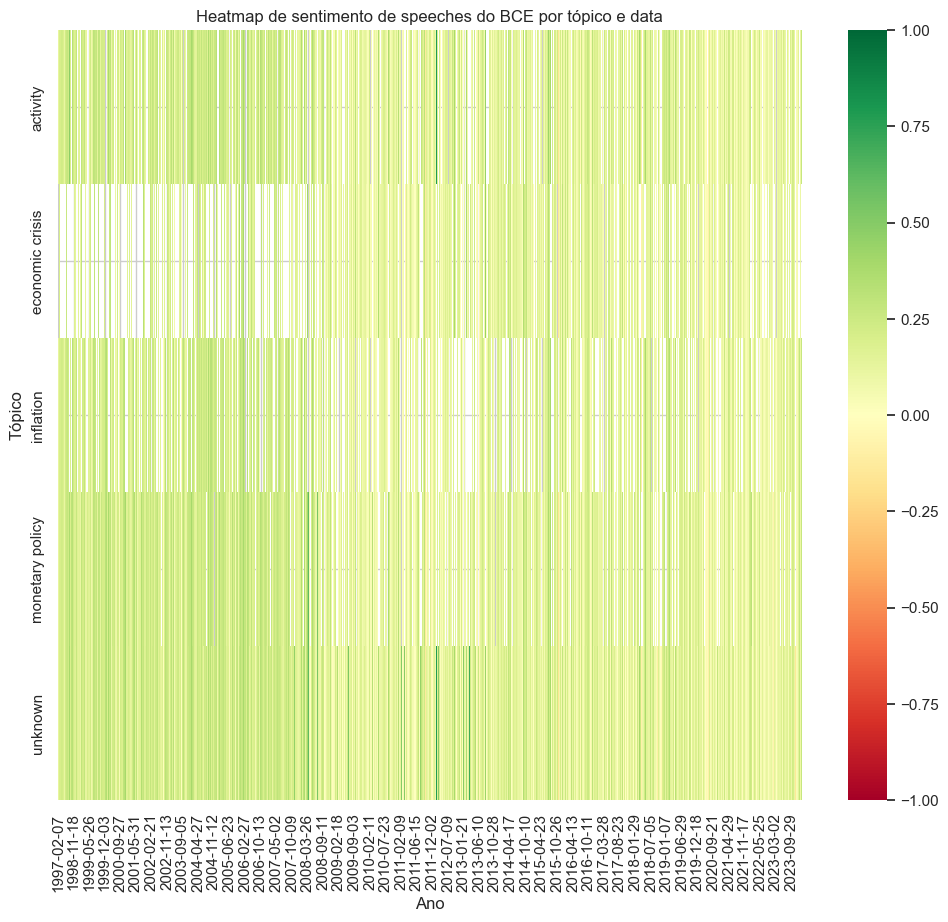

In [ ]:
new_data_pivot = new_data.pivot_table(values="sentiment", index="topic", columns="date_x", aggfunc="mean")

plt.figure(figsize=(12, 10))

sns.heatmap(new_data_pivot, cmap="RdYlGn", vmin=-1, vmax=1)
plt.title("Heatmap de sentimento de speeches do BCE por tópico e data")
plt.xlabel("Ano")
plt.ylabel("Tópico")
plt.show()

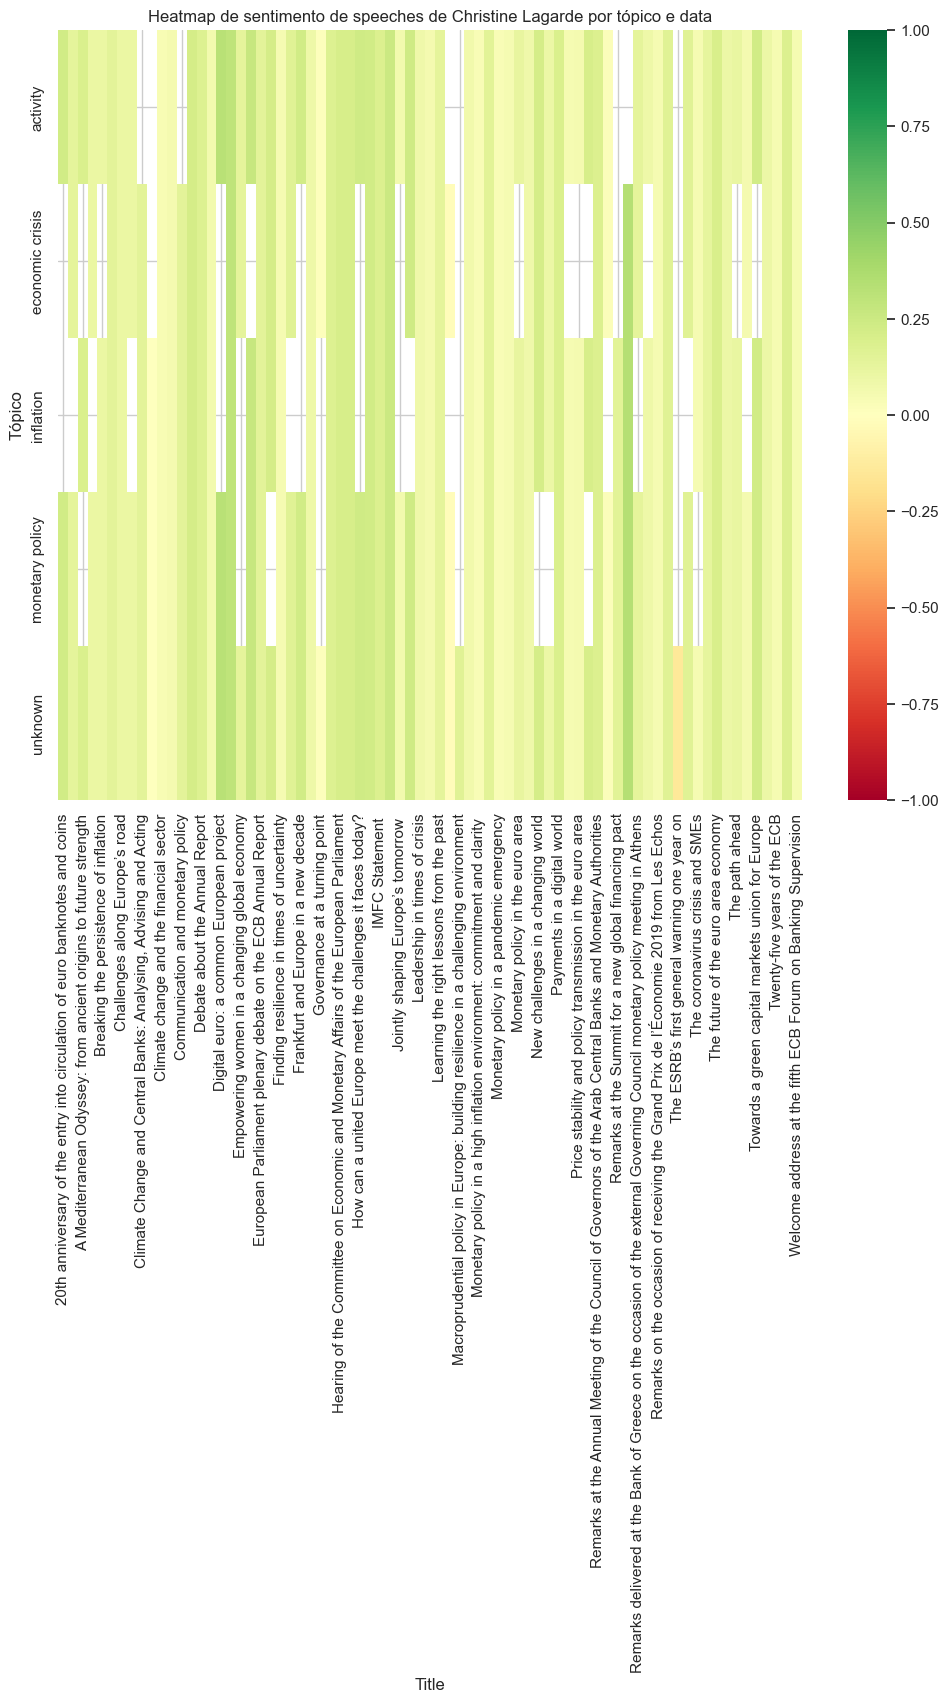

In [ ]:
# Filtrando o DataFrame para incluir apenas as falas de Christine Lagarde
lagarde_data = new_data[new_data['speakers_x'] == 'Christine Lagarde']

# Criando a tabela pivot com a média dos sentimentos
new_data_pivot = lagarde_data.pivot_table(values="sentiment", index="topic", columns="title")

plt.figure(figsize=(12, 10))
# Criando o heatmap com o mapa de cores RdYlGn e limites de cor configurados para -1 a 1
sns.heatmap(new_data_pivot, cmap="RdYlGn", vmin=-1, vmax=1)
plt.title("Heatmap de sentimento de speeches de Christine Lagarde por tópico e data")
plt.xlabel("Title")
plt.ylabel("Tópico")
plt.show()


In [ ]:
def detect_paragraphs(doc):
    paragraphs = []
    current_paragraph = []
    prev_sent = None

    for sent in doc.sents:
        if prev_sent is not None and sent.similarity(prev_sent) < 0.5:  
            paragraphs.append(' '.join(current_paragraph))
            current_paragraph = []
        current_paragraph.append(sent.text)
        prev_sent = sent

    if current_paragraph:  
        paragraphs.append(' '.join(current_paragraph))

    return paragraphs

def get_paragraphs(df):
    df['paragraphs'] = None 
    for idx, row in df.iterrows():
        text = row["contents_x"]
        doc = nlp(text)
        paragraphs = detect_paragraphs(doc)
        df.at[idx, "paragraphs"] = paragraphs  

    return df  # Retorna o DataFrame com a nova coluna


In [ ]:
inflation_definitions = {
    'inflation': 'The rate at which the general level of prices for goods and services is rising, and, subsequently, eroding purchasing power.',
    'prices': 'The amount of money expected, required, or given in payment for something.',
    'deflation': 'A decrease in the general price level of goods and services, often associated with an increase in the value of money.',
    'target': 'A specific level or condition that a plan is intended to achieve, often used in the context of economic targets like inflation targets.',
    'consumer prices': 'Prices of goods and services bought by households, measured by the Consumer Price Index (CPI).',
    'CPI': 'Consumer Price Index, a measure that examines the weighted average of prices of a basket of consumer goods and services, such as transportation, food, and medical care.',
    'PPI': 'Producer Price Index, a measure of the average changes in prices received by domestic producers for their output.'
}
activity_definitions = {
    'activity': 'The level of economic actions or transactions occurring within an economy, often related to production and work.',
    'recovery': 'A period of economic growth following a contraction or recession, where output and employment start to rise again.',
    'recession': 'A significant decline in economic activity spread across the economy, lasting more than a few months, typically visible in GDP, real income, employment, industrial production, and wholesale-retail sales.',
    'expansion': 'The phase of the business cycle where the economy moves from a trough to a peak, characterized by an increase in economic activity such as production, employment, and output.',
    'output': 'The total amount of goods and services produced by an economic system over a specific period.',
    'demand': 'The quantity of a good or service that consumers are willing and able to purchase at various prices during a given period.',
    'supply': 'The total amount of a specific good or service that is available to consumers at current price levels.',
    'GDP': 'Gross Domestic Product, the total monetary or market value of all the finished goods and services produced within a country\'s borders in a specific time period.',
    'employment': 'The state of having paid work, or the total number of people currently employed in the economy.',
    'unemployment': 'The situation where individuals who are capable of working and are actively seeking work are unable to find employment.',
    'labor market': 'The supply and demand for labor, in which employers seek to hire workers, and workers seek to find jobs.'
}

economic_crisis_definitions = {
    'crisis': 'A severe and sudden event in financial markets that disrupts the economy and leads to financial instability, often characterized by rapid declines in asset prices and failures of key businesses and banks.',
    'recession': 'A period of temporary economic decline during which trade and industrial activity are reduced, generally identified by a fall in GDP in two successive quarters.',
    'depression': 'A prolonged period of extreme economic downturn, featuring significant declines in income and employment, high rates of bankruptcies and often deflation.',
    'bailout': 'Financial support or rescue provided by a government or financial institution to a failing business or economy to prevent the potential negative consequences of failure.',
    'stimulus': 'Economic measures taken by a government to encourage economic growth, typically involving increased public spending and tax reductions.',
    'austerity': 'Economic policies implemented by a government aimed at reducing public deficits during adverse economic conditions. These policies involve reducing government spending, increasing taxes, and reducing public benefits.',
    'bankruptcy': 'A legal process through which individuals or businesses unable to meet their financial obligations can seek relief from some or all of their debts.',
    'default': 'The failure to meet the legal obligations of a loan, typically when the debtor does not make their required payments to creditors.'
}

monetary_policy_definitions = {
    'monetary policy': 'The process by which a central bank, currency board, or other regulatory committee manages the money supply and interest rates to influence economic growth and stability.',
    'interest rates': 'The amount charged, expressed as a percentage of principal, by a lender to a borrower for the use of assets.',
    'central bank': 'A national bank that provides financial and banking services for its country\'s government and commercial banking system, as well as implementing the government\'s monetary policy and issuing currency.',
    'money supply': 'The total amount of monetary assets available in an economy at a specific time, including cash, coins, and balances held in checking and savings accounts.',
    'quantitative easing': 'A monetary policy where a central bank purchases government securities or other securities from the market to lower interest rates and increase the money supply.',
    'policy rate': 'The interest rate set by the central bank that guides the overall interest rates in the economy, including the rates at which banks lend to one another and to the public.',
    'rate cut': 'A decision by a central bank to lower interest rates, intended to stimulate economic growth by making borrowing cheaper.',
    'rate hike': 'An increase in the interest rate set by the central bank, intended to control inflation by making borrowing more expensive.',
    'forward guidance': 'A tool used by a central bank to communicate with investors about their future monetary policy decisions, helping to manage the expectations of future interest rates.',
    'open market operations': 'Activities by a central bank to buy or sell government bonds on the open market to regulate the money supply.',
    'reserve requirements': 'Regulations set by the central bank that determine the minimum amount of reserves each bank must hold against deposits, as a way to control how much banks can lend.'
}

all_definitions = {
    'Inflation and Prices': inflation_definitions,
    'Economic Activity': activity_definitions,
    'Economic Crisis': economic_crisis_definitions,
    'Monetary Policy': monetary_policy_definitions
}

In [ ]:
def find_related_theme(phrase, all_definitions):
    # Processar a frase dada
    doc_phrase = nlp(phrase)
    
    # Armazenar a similaridade máxima e o tema correspondente
    max_similarity = -1
    related_theme = None
    
    # Iterar sobre cada tema e suas definições
    for theme, definitions in all_definitions.items():
        similarities = []
        # Calcular a similaridade da frase com cada definição no tema
        for key, definition in definitions.items():
            doc_definition = nlp(definition)
            similarity = doc_phrase.similarity(doc_definition)
            similarities.append(similarity)
        
        # Calcular a média das similaridades para o tema
        theme_similarity = np.mean(similarities)
        
        # Verificar se este tema tem a maior similaridade até agora
        if theme_similarity > max_similarity:
            max_similarity = theme_similarity
            related_theme = theme
        
    return related_theme, max_similarity

def analyze_paragraphs(paragraphs, all_definitions):
    results = []
    for paragraph in paragraphs:
        theme, similarity = find_related_theme(paragraph, all_definitions)
        results.append({
            'paragraph': paragraph,
            'related_theme': theme,
            'similarity_score': similarity
        })
    return results

In [ ]:
data_paragraphs = get_paragraphs(new_data.iloc[:10])

C:\Users\Isas_\AppData\Local\Temp\ipykernel_22084\376684708.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['paragraphs'] = None  # Cria a coluna paragraphs se ainda não existir
C:\Users\Isas_\AppData\Local\Temp\ipykernel_22084\376684708.py:7: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  if prev_sent is not None and sent.similari

In [ ]:
analyze_paragraphs(data_paragraphs['paragraphs'][0], all_definitions)

C:\Users\Isas_\AppData\Local\Temp\ipykernel_22084\1799831285.py:15: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarity = doc_phrase.similarity(doc_definition)


[{'paragraph': 'As we approach the end of this legislative term, I wish to sincerely thank this Parliament for collaborating in guiding Europe through economic headwinds and geopolitical upheavals, always with the shared vision of bolstering prosperity and fortifying our resilience. Building on this collaborative spirit, today’s debate on your draft resolution on the ECB Annual Report is a pillar of the ongoing dialogue between our two institutions; indeed, it is fundamental to the ECB’s accountability which ensures the democratic legitimacy of our actions. Let me start by outlining the current state of the euro area economy and our monetary policy stance. I will then focus on the need for a common European response to strengthen euro area resilience and competitiveness. Bringing inflation back to target in a challenging economic and geopolitical environment The euro area has been facing significant headwinds from a series of sudden and consecutive shocks which pushed inflation very hi

In [ ]:
for i in range(len(new_data["paragraphs"][0])):
    print(new_data["paragraphs"][0][i])
    print("===")

As we approach the end of this legislative term, I wish to sincerely thank this Parliament for collaborating in guiding Europe through economic headwinds and geopolitical upheavals, always with the shared vision of bolstering prosperity and fortifying our resilience. Building on this collaborative spirit, today’s debate on your draft resolution on the ECB Annual Report is a pillar of the ongoing dialogue between our two institutions; indeed, it is fundamental to the ECB’s accountability which ensures the democratic legitimacy of our actions. Let me start by outlining the current state of the euro area economy and our monetary policy stance. I will then focus on the need for a common European response to strengthen euro area resilience and competitiveness. Bringing inflation back to target in a challenging economic and geopolitical environment The euro area has been facing significant headwinds from a series of sudden and consecutive shocks which pushed inflation very high in the wake o

In [ ]:
def create_distance_matrix(sentences):
    n = len(sentences)

    distance_matrix = np.zeros((n, n))

    for sentence in sentences:
        for i in range(n):
            for j in range(i + 1, n):

                distance = j-i
                distance_matrix[i, j] = distance

    distance_matrix = distance_matrix + distance_matrix.T

    return distance_matrix

sentences = ["frase 1", "frase 2", "frase 3"]
matrix = create_distance_matrix(sentences)
print(matrix)


[[0. 1. 2.]
 [1. 0. 1.]
 [2. 1. 0.]]
